<a href="https://colab.research.google.com/github/MADHUPRIYAAA/2303a51583-batch-22/blob/main/project%20code%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔍 Training Logistic Regression ...
Best Params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
              precision    recall  f1-score   support

        High       0.86      0.80      0.83        75
         Low       0.81      0.87      0.84        76

    accuracy                           0.83       151
   macro avg       0.84      0.83      0.83       151
weighted avg       0.84      0.83      0.83       151


🔍 Training Decision Tree ...
Best Params for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
              precision    recall  f1-score   support

        High       0.81      0.73      0.77        75
         Low       0.76      0.83      0.79        76

    accuracy                           0.78       151
   macro avg       0.78      0.78      0.78       151
weighted avg       0.78      0.78      0.78       151


🔍 Training KNN ...
Best Params for KNN: {'classifier__n_neigh

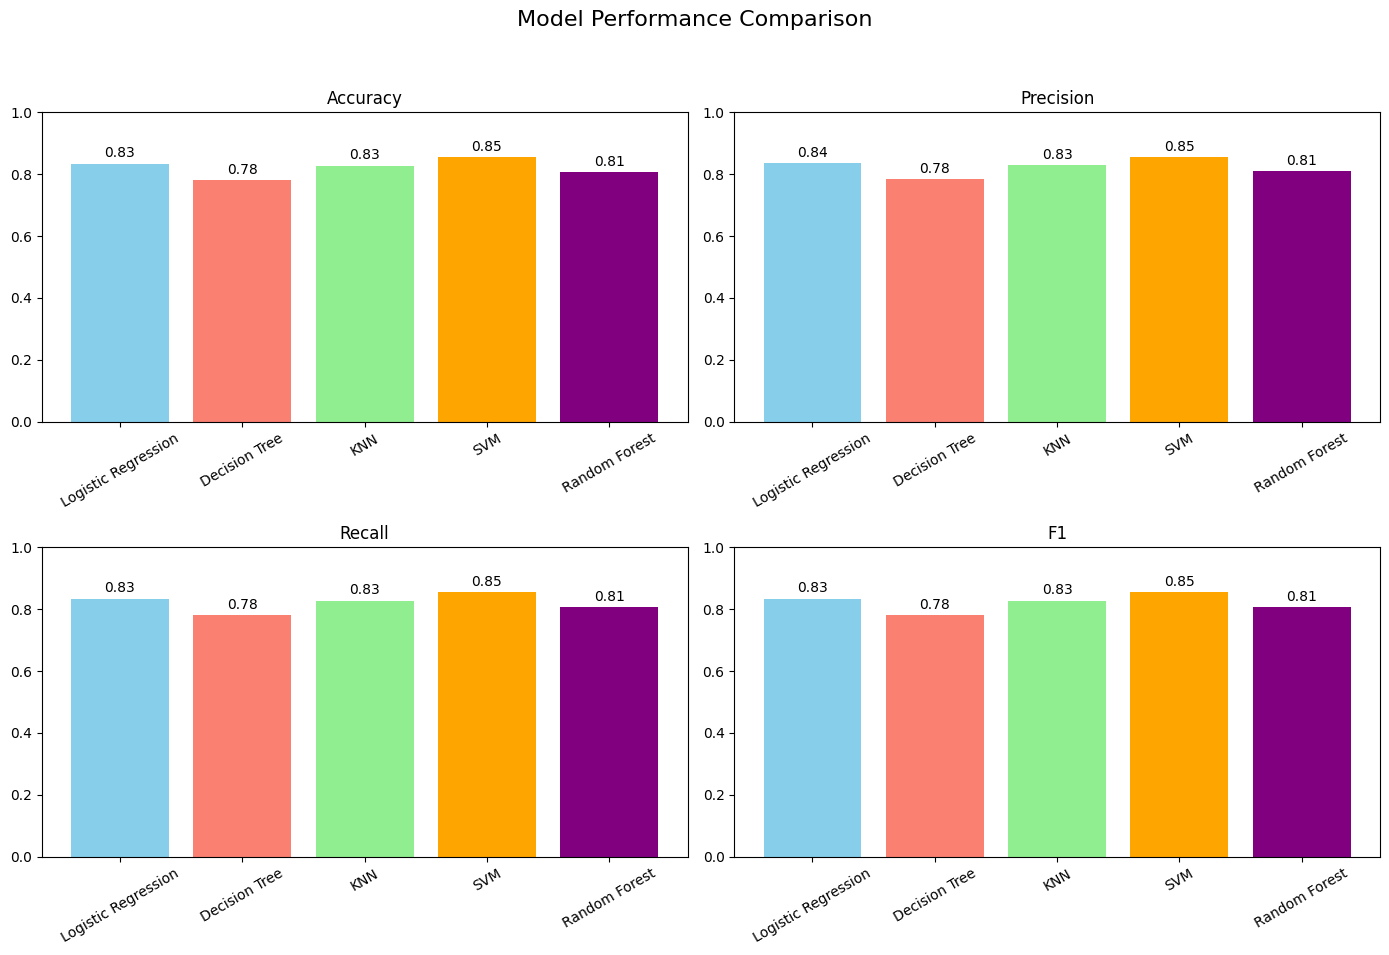

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# --- Data Loading ---
def load_and_prepare_data(filepath='nutrition_cf - Sheet5 (1).csv'):
    df = pd.read_csv(filepath)

    # Numeric fix
    df['Carbon Footprint(kg CO2e)'] = pd.to_numeric(df['Carbon Footprint(kg CO2e)'], errors='coerce').fillna(0)

    # Binary classification (higher accuracy than 3 classes)
    median_cf = df['Carbon Footprint(kg CO2e)'].median()
    df['Carbon_Footprint_Category'] = np.where(df['Carbon Footprint(kg CO2e)'] <= median_cf, 'Low', 'High')

    # Drop unused
    df = df.drop(['Carbon Footprint(kg CO2e)', 'Food', 'Ingredients'], axis=1)

    return df.drop(['Carbon_Footprint_Category'], axis=1), df['Carbon_Footprint_Category']

# --- Run Analysis ---
def run_analysis():
    X, y = load_and_prepare_data()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    # Models + params
    param_grid = {
        "Logistic Regression": {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2'],
            'classifier__solver': ['lbfgs']
        },
        "Decision Tree": {
            'classifier__max_depth': [3, 5, 10, None],
            'classifier__min_samples_split': [2, 5, 10]
        },
        "KNN": {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance']
        },
        "SVM": {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        },
        "Random Forest": {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [5, 10, None],
            'classifier__min_samples_split': [2, 5, 10]
        }
    }

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(random_state=42, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced')
    }

    results = {}

    for name, model in models.items():
        print(f"\n🔍 Training {name} ...")
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])

        grid = GridSearchCV(pipeline, param_grid[name], cv=5, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)

        # Collect metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name] = {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'best_params': grid.best_params_
        }

        print(f"Best Params for {name}: {grid.best_params_}")
        print(classification_report(y_test, y_pred))

    # Plot comparison
    plot_results(results)

def plot_results(results):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    model_names = list(results.keys())

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Model Performance Comparison", fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        values = [results[m][metric] for m in model_names]
        ax.bar(model_names, values, color=['skyblue','salmon','lightgreen','orange','purple'])
        ax.set_title(f"{metric.capitalize()}", fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='x', rotation=30)
        for idx, val in enumerate(values):
            ax.text(idx, val+0.02, f"{val:.2f}", ha='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Entry ---
if __name__ == "__main__":
    run_analysis()
